In [1]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [9]:
data_dir = '/data200T/SPACseq/HD/output/subq/outs/binned_outputs/square_008um/'
fdata = sc.read(data_dir + 'combined_cellcharter.h5ad')

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/anndata/__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [3]:
gdata = sc.read(data_dir + 'guide_combined.h5ad')
gdata = gdata[fdata.obs_names].copy()

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/anndata/__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


# Same guide detections

In [15]:
data_dir = '/data200T/SPACseq/HD/output/subq/outs/binned_outputs/square_016um/'
gdata_raw = sc.read(data_dir + 'combined.h5ad')
gdata_raw = gdata_raw[:, gdata_raw.var_names.str.startswith('sg')]

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/anndata/__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [38]:
cnt_df = pd.DataFrame({
    'gene': gdata_raw.var_names,
    'cnt': gdata_raw.X.toarray().sum(axis=0)
}).set_index('gene').sort_values(by='cnt', ascending=False)
cnt_df['guide'] = cnt_df.index.str.split('_').str[0]
cnt_df['rank'] = np.arange(len(cnt_df))
top_genes = cnt_df.groupby('guide')['rank'].mean().sort_values(ascending=True).head(10)

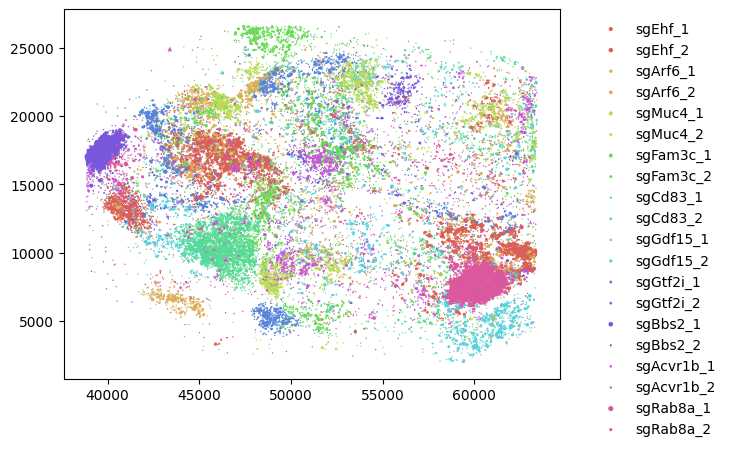

In [39]:
colors = sns.color_palette("hls", len(top_genes))
for i, gene in enumerate(top_genes.index):
    sns.scatterplot(x=gdata_raw.obsm['spatial'][:, 0], y=gdata_raw.obsm['spatial'][:, 1], 
                s=gdata_raw[:, gene + '_1'].X.toarray().flatten(), legend=False, color=colors[i], edgecolor='none', label=gene + '_1')
    sns.scatterplot(x=gdata_raw.obsm['spatial'][:, 0], y=gdata_raw.obsm['spatial'][:, 1], 
                s=gdata_raw[:, gene + '_2'].X.toarray().flatten(), legend=False, color=colors[i], edgecolor='none', label=gene + '_2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)

# Differential expression

In [10]:
sc.pp.normalize_total(fdata, target_sum=1e4)

In [11]:
fdata.obs.cluster = fdata.obs.cluster.astype('category')
sc.tl.rank_genes_groups(fdata, 'cluster', method='t-test')

In [12]:
pval_cutoff = 1
top_n = 1000000

result = fdata.uns['rank_genes_groups']
groups = result['names'].dtype.names

top_genes_df = pd.DataFrame()

for group in groups:
    genes = result['names'][group]
    log2fc = result['logfoldchanges'][group]
    padj = result['pvals_adj'][group]
    score = result['scores'][group]
    
    data = pd.DataFrame({
        'Gene': genes,
        'Log2FoldChange': log2fc,
        'padj': padj,
        'score': score,
        'Cluster': group
    })
    
    filtered_data = data[data['padj'] < pval_cutoff]
    sorted_data = filtered_data.sort_values(by='score', ascending=False)
    top_genes = sorted_data.head(top_n)
    top_genes_df = pd.concat([top_genes_df, top_genes], ignore_index=True)

deg = top_genes_df["Gene"].unique().tolist()
top_genes_df.to_csv('./DEG.csv', index=False, sep="\t")
top_genes_df

,Gene,Log2FoldChange,padj,score,Cluster
0,Col1a1,120.610542,0.0,108.584160,0
1,Col1a2,74.435928,0.0,104.192749,0
2,Col3a1,102.737221,0.0,97.389519,0
3,Bgn,27.023289,0.0,96.139061,0
4,Apoe,40.758831,0.0,93.696655,0
...,...,...,...,...,...
114711,Spp1,-14.629337,0.0,-193.544312,6
114712,Krt8,-14.717453,0.0,-208.760468,6
114713,H1f0,-14.851746,0.0,-226.152481,6
114714,Mt2,-25.471384,0.0,-248.138184,6


In [13]:
plot_df = top_genes_df.groupby('Cluster').head(5)

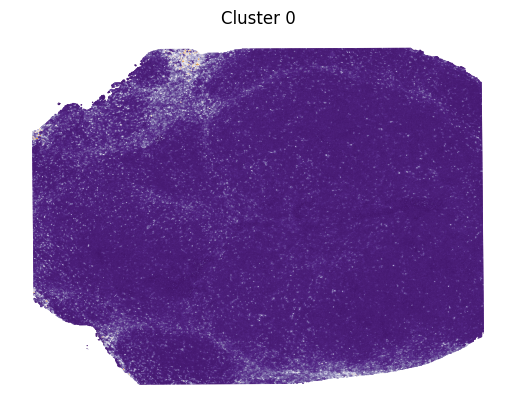

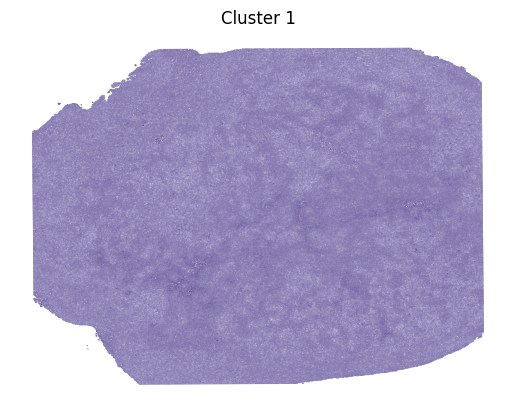

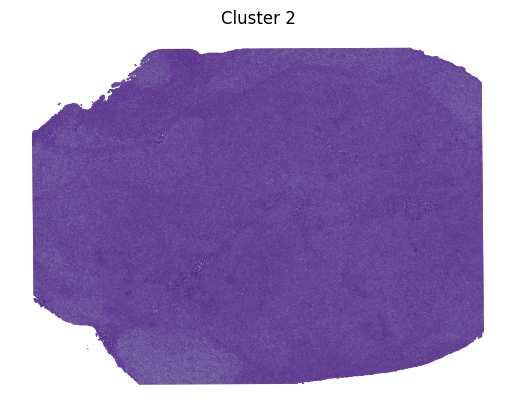

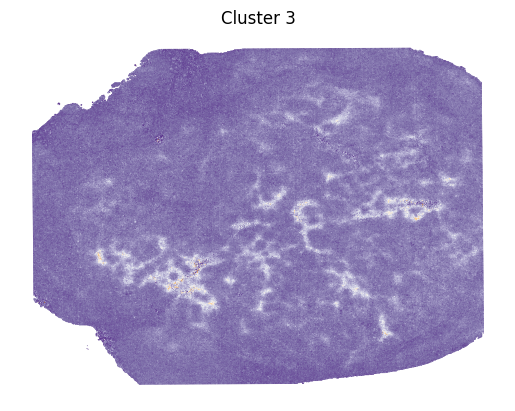

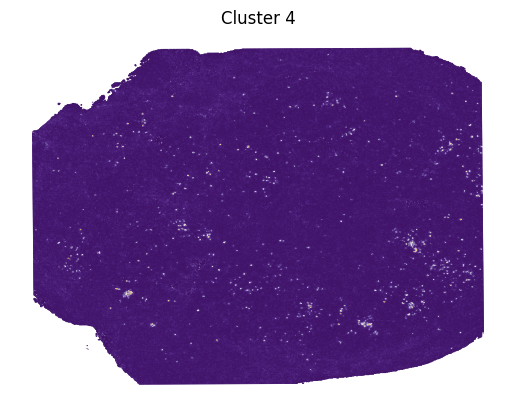

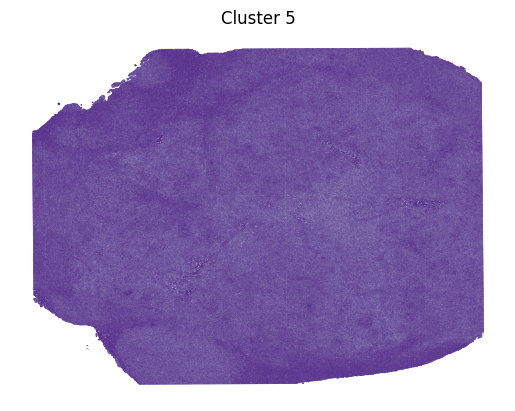

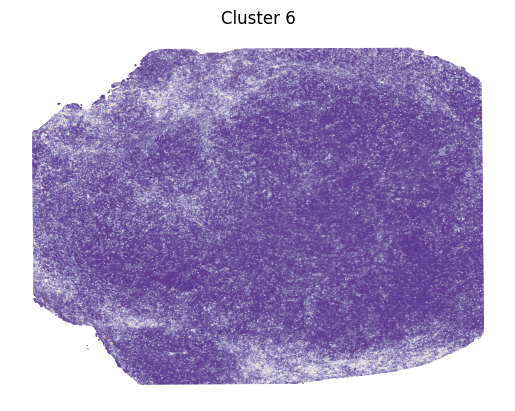

In [14]:
for i, cluster in enumerate(plot_df['Cluster'].unique()):
    sc.tl.score_genes(fdata, plot_df.loc[plot_df['Cluster'] == cluster]['Gene'].tolist(), score_name=f'deg_cluster_{cluster}')
    plt.figure()
    sns.scatterplot(x=fdata.obsm['spatial'][:, 0], y=fdata.obsm['spatial'][:, 1],
                    c=fdata.obs[f'deg_cluster_{cluster}'].tolist(), cmap='PuOr_r', s=0.5, edgecolor='none')
    plt.gca().invert_yaxis()
    plt.xticks([])
    plt.yticks([])
    plt.title(f'Cluster {cluster}')
    sns.despine(left=True, bottom=True)
    plt.show()

# Plotting

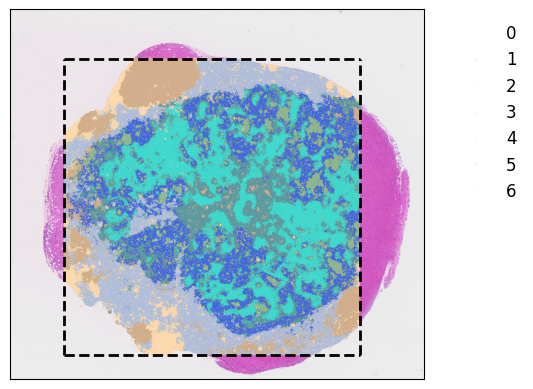

In [18]:
data_dir = '/data200T/SPACseq/HD/output/subq/outs/binned_outputs/square_008um/'
image_path = data_dir + 'spatial/tissue_hires_image.png'
image = plt.imread(image_path)
image_cropped = image[:, image.shape[1] // 2:]

scale_factor = 0.08734006
plt.imshow(image_cropped)

colors = ['navajowhite', 'royalblue', 'tan', 'turquoise', 'darkseagreen', 'cadetblue', 'lightsteelblue']

sns.scatterplot(x=fdata.obsm['spatial'][:, 0] * scale_factor - image.shape[1] // 2, 
                y=fdata.obsm['spatial'][:, 1] * scale_factor,
                hue=fdata.obs.cluster.tolist(), palette=colors, s=0.5, edgecolor='none', alpha=0.5)
plt.hlines(y=fdata.obsm['spatial'][:, 1].min() * scale_factor,
           xmin=fdata.obsm['spatial'][:, 0].min() * scale_factor - image.shape[1] // 2,
           xmax=fdata.obsm['spatial'][:, 0].max() * scale_factor - image.shape[1] // 2, color='black', linewidth=2, linestyle='--')
plt.vlines(x=fdata.obsm['spatial'][:, 0].min() * scale_factor - image.shape[1] // 2,
           ymin=fdata.obsm['spatial'][:, 1].min() * scale_factor,
           ymax=fdata.obsm['spatial'][:, 1].max() * scale_factor, color='black', linewidth=2, linestyle='--')
plt.hlines(y=fdata.obsm['spatial'][:, 1].max() * scale_factor,
           xmin=fdata.obsm['spatial'][:, 0].min() * scale_factor - image.shape[1] // 2,
           xmax=fdata.obsm['spatial'][:, 0].max() * scale_factor - image.shape[1] // 2, color='black', linewidth=2, linestyle='--')
plt.vlines(x=fdata.obsm['spatial'][:, 0].max() * scale_factor - image.shape[1] // 2,
           ymin=fdata.obsm['spatial'][:, 1].min() * scale_factor,
           ymax=fdata.obsm['spatial'][:, 1].max() * scale_factor, color='black', linewidth=2, linestyle='--')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False, fontsize='large')  # 改变legend的字体大小
plt.gca().invert_yaxis()
plt.xticks([])
plt.yticks([])

plt.rcParams['pdf.fonttype'] = 42
plt.savefig('./plots/cluster_plot.pdf', bbox_inches='tight', format='pdf')
plt.show()